In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn import datasets, metrics

# Loading the data from Sklearn's datasets
iris = datasets.load_iris()
X = iris.data
y = iris.target

# Standarizing the features
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

In [8]:
labels = KMeans(n_clusters=2).fit_predict(X_std)
print(metrics.silhouette_score(X_std, labels, metric='euclidean'))

0.5817500491982808


The silhouette coefficient for two clusters is higher than with three clusters, even though the true number of clusters for the iris dataset is three. This is probably because two of the clusters are really close, and the third is linearly separable from the other two. For the silhouette coefficient computation the nearest cluster when there are three clusters is super close for the adjacent clusters; with only only two clusters, they are far apart which inflates the quantity b_i - a_i.

In [9]:
from sqlalchemy import create_engine
import warnings

warnings.filterwarnings('ignore')

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'heartdisease'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

df = pd.read_sql_query('select * from heartdisease',con=engine)

engine.dispose()

In [10]:
# Make sure the number of rows divides evenly into four samples.
rows = df.shape[0] - df.shape[0] % 2
df = df.iloc[:rows, :]

# Break into a set of features and a variable for the known outcome.
X = df.iloc[:, :13]
y = df.iloc[:, 13]

# Replace some random string values.
X = X.replace(to_replace='?', value=0)

# Binarize y so that 1 means heart disease diagnosis and 0 means no diagnosis.
y = np.where(y > 0, 0, 1)

# Normalize
X_std = StandardScaler().fit_transform(X)

# Data frame to store features and predicted cluster memberships.
ypred = pd.DataFrame()

# Create the two-feature PCA for graphing purposes.
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_std)

# Split the data into four equally-sized samples. First we break it in half:
X_half1, X_half2, X_pcahalf1, X_pcahalf2 = train_test_split(
    X_std,
    X_pca,
    test_size=0.5)

# Pass a list of tuples and a counter that increments each time we go
# through the loop. The tuples are the data to be used by k-means,
# and the PCA-derived features for graphing. We use k-means to fit a
# model to the data, then store the predicted values and the two-feature
# PCA solution in the data frame.
for counter, data in enumerate([
    (X_half1, X_pcahalf1),
    (X_half2, X_pcahalf2)]):
    
    # Put the features into ypred.
    ypred['pca_f1' + '_sample' + str(counter)] = data[1][:, 0]
    ypred['pca_f2' + '_sample' + str(counter)] = data[1][:, 1]
    
    # Generate cluster predictions and store them for clusters 2 to 4.
    for nclust in range(2, 5):
        pred = KMeans(n_clusters=nclust).fit_predict(data[0])
        ypred['clust' + str(nclust) + '_sample' + str(counter)] = pred

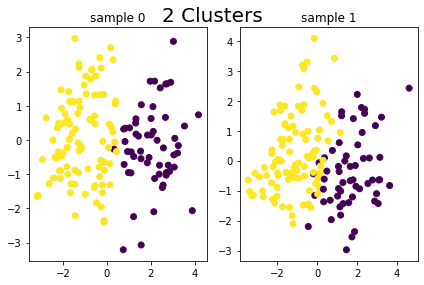

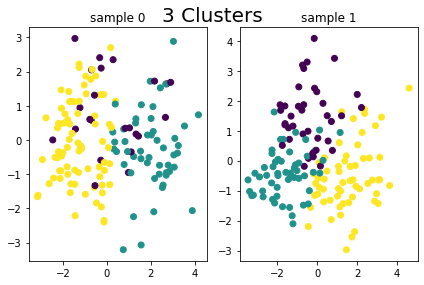

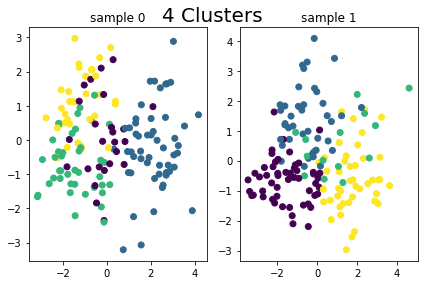

In [11]:

# For each  number of clusters, plot the clusters using the
# pca features for each sample.
for cluster in range(2, 5):
    
    # Make a grid of subplots.
    f, axarr = plt.subplots(1, 2)
    
    # Make a plot for each sample.
    for i in range(2):
        
        # PCA-created features.
        x_sub = ypred['pca_f1_sample{}'.format(i)]
        y_sub = ypred['pca_f2_sample{}'.format(i)]
        
        # Cluster assignments.
        c = ypred['clust{}_sample{}'.format(cluster, i)]
        
        # Assign the subplot to its place on the grid.
        axarr[i].scatter(x_sub, y_sub, c=c)
        axarr[i].set_title('sample {}'.format(i))
        axarr[i].set_xlim()
        axarr[i].set_ylim()
    
    # Space out the plots so that the headings don't overlap axis values.
    plt.suptitle('{} Clusters'.format(cluster), fontsize=20)
    plt.tight_layout()
    plt.show()

Two clusters is a clear winner, which is no surprise since the real number of clusters is two.

In [15]:
#two clusters
y_pred = KMeans(n_clusters=2).fit_predict(X_std)
metrics.adjusted_rand_score(y, y_pred)

0.43661540614807665

In [16]:
#three clusters
y_pred = KMeans(n_clusters=3).fit_predict(X_std)
metrics.adjusted_rand_score(y, y_pred)

0.27992514499139165

In [17]:
#four clusters
y_pred = KMeans(n_clusters=4).fit_predict(X_std)
metrics.adjusted_rand_score(y, y_pred)

0.1988281476191759

ARI is best for two clusters, since the score is the highest.

In [18]:
#two clusters
y_pred = KMeans(n_clusters=2).fit_predict(X_std)
metrics.silhouette_score(X_std, y_pred, metric='euclidean')

0.17440650461256255

In [19]:
#three clusters
y_pred = KMeans(n_clusters=3).fit_predict(X_std)
metrics.silhouette_score(X_std, y_pred, metric='euclidean')

0.1292628104534446

In [20]:
#four clusters
y_pred = KMeans(n_clusters=4).fit_predict(X_std)
metrics.silhouette_score(X_std, y_pred, metric='euclidean')

0.1340004040352034

Score is the best (i.e. closest to 1) for two clusters again.